In [56]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
import glob
from glob import glob
glob('/content/drive/MyDrive/NLP_project_CNN/train_item')

['/content/drive/MyDrive/NLP_project_CNN/train_item']

In [58]:
import glob
from glob import glob
glob('/content/drive/MyDrive/NLP_project_CNN/test_item')

['/content/drive/MyDrive/NLP_project_CNN/test_item']

# Step-by-step VGG19-based image classification with accuracy improvement
# --------------------------------------------------------------------------

# Step 1: Import Required Libraries
# These are essential for image processing, model creation, and training.

In [59]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [60]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Step 2: Set Directory Paths for Dataset
# Replace these paths with the correct paths to your dataset.

In [61]:
# Paths to the dataset folders
train_data_path = '/content/drive/MyDrive/NLP_project_CNN/train_item'
val_data_path = '/content/drive/MyDrive/NLP_project_CNN/test_item'


# Step 3: Data Preprocessing with Augmentation
# Augmentation helps improve generalization. Rescaling normalizes pixel values.

In [62]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 3700 images belonging to 2 classes.
Found 1082 images belonging to 2 classes.


# Step 4: Load VGG19 Pre-trained Model (without top)
# We use imagenet weights and exclude the top layers to customize classification.

In [63]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Initially freeze all layers

# Step 5: Add Custom Classification Layers
# Flatten -> Dense -> BatchNorm -> Dropout -> Dense -> Output

In [64]:
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

model_sample = Model(inputs=base_model.input, outputs=predictions)

# Step 6: Unfreeze Last Few Layers for Fine-tuning
# Allows model to adapt ImageNet weights to your custom dataset.

In [65]:
for layer in base_model.layers[-4:]:
    layer.trainable = True


# Step 7: Compile the Model
# Use Adam optimizer with a low learning rate for fine-tuning

In [66]:
model_sample.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Step 8: Set Up Callbacks
# EarlyStopping halts training if validation loss stops improving
# ReduceLROnPlateau decreases learning rate on plateaus

In [67]:
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

# Step 9: Train the Model
# Fit the model using training and validation generators with callbacks

In [68]:
history = model_sample.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[checkpoint_callback, early_stop, reduce_lr]
)

Epoch 1/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.6309 - loss: 0.7510

116/116 ━━━━━━━━━━━━━━━━━━━━ 106s 845ms/step - accuracy: 0.6314 - loss: 0.7501 - val_accuracy: 0.7366 - val_loss: 0.4574 - learning_rate: 1.0000e-05
Epoch 2/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.7965 - loss: 0.4492

116/116 ━━━━━━━━━━━━━━━━━━━━ 97s 836ms/step - accuracy: 0.7967 - loss: 0.4489 - val_accuracy: 0.8161 - val_loss: 0.3600 - learning_rate: 1.0000e-05
Epoch 3/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.8541 - loss: 0.3454

116/116 ━━━━━━━━━━━━━━━━━━━━ 94s 806ms/step - accuracy: 0.8542 - loss: 0.3452 - val_accuracy: 0.8429 - val_loss: 0.3345 - learning_rate: 1.0000e-05
Epoch 4/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.8839 - loss: 0.2767

116/116 ━━━━━━━━━━━━━━━━━━━━ 92s 795ms/step - accuracy: 0.8839 - loss: 0.2767 - val_accuracy: 0.8734 - val_loss: 0.2892 - learning_rate: 1.0000e-05
Epoch 5/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 93s 794ms/step - accuracy: 0.8889 - loss: 0.2631 - val_accuracy: 0.8743 - val_loss: 0.3067 - learning_rate: 1.0000e-05
Epoch 6/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.9147 - loss: 0.2056

116/116 ━━━━━━━━━━━━━━━━━━━━ 92s 791ms/step - accuracy: 0.9147 - loss: 0.2055 - val_accuracy: 0.8882 - val_loss: 0.2740 - learning_rate: 1.0000e-05
Epoch 7/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 94s 794ms/step - accuracy: 0.9146 - loss: 0.2052 - val_accuracy: 0.8835 - val_loss: 0.3036 - learning_rate: 1.0000e-05
Epoch 8/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 97s 838ms/step - accuracy: 0.9269 - loss: 0.1804 - val_accuracy: 0.8817 - val_loss: 0.3444 - learning_rate: 1.0000e-05
Epoch 9/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 93s 800ms/step - accuracy: 0.9305 - loss: 0.1566 - val_accuracy: 0.8900 - val_loss: 0.3094 - learning_rate: 1.0000e-05
Epoch 10/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 91s 788ms/step - accuracy: 0.9344 - loss: 0.1595 - val_accuracy: 0.8872 - val_loss: 0.3042 - learning_rate: 2.0000e-06


In [69]:
# Optional Step 10: Save Final Model
model_sample.save('final_vgg19_model.keras')

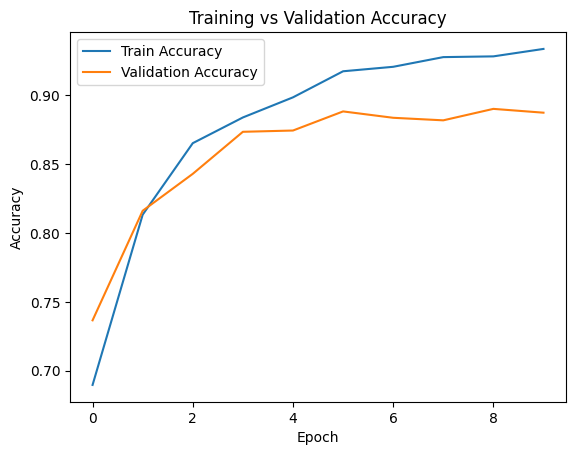

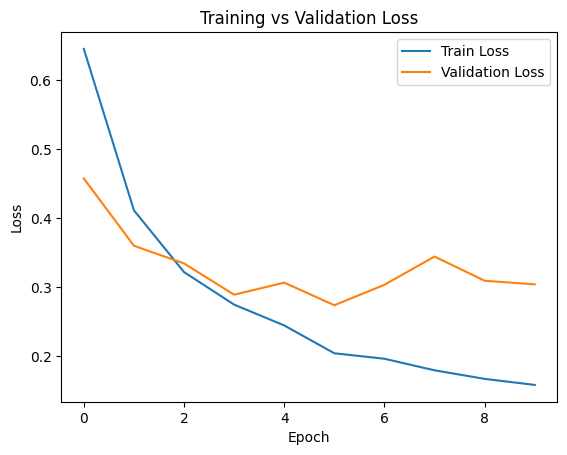

In [70]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()
